# Snorkel for Place of Birth Relation Extraction

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from snorkel import SnorkelSession
session = SnorkelSession()

## Preprocessing corpus

We use a `TSVDocPreprocessor` to load documents into a local Sqlite3 session.

In [2]:
from snorkel.parser import TSVDocPreprocessor
from snorkel.parser.spacy_parser import Spacy
from snorkel.parser import CorpusParser

doc_preprocessor = TSVDocPreprocessor('data/pob_pod.tsv')
corpus_parser = CorpusParser(parser=Spacy())
%time corpus_parser.apply(doc_preprocessor, parallelism=1)

Clearing existing...
Running UDF...
CPU times: user 1min 55s, sys: 3.79 s, total: 1min 59s
Wall time: 2min 23s


Verifying our documents exist:

In [3]:
from snorkel.models import Document, Sentence

print("Documents:", session.query(Document).count())
print("Sentences:", session.query(Sentence).count())

Documents: 11657
Sentences: 38614


## Generating Candidates

NER on places is hard. To make it easier, we'll use a dataset of cities/subcountries/countries from geonames. To get it, run

```bash
cd data
python download_locs.py
```

In [4]:
with open('data/locs.txt', 'r') as fin:
    locs = {loc.strip(): True for loc in fin}
    locs = {loc: b for loc, b in locs.items() if loc not in
           ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September',
            'October', 'November', 'December']}

In [5]:
from snorkel.models import candidate_subclass
from snorkel.candidates import Ngrams, CandidateExtractor
from snorkel.matchers import PersonMatcher, LocationMatcher, DictionaryMatch, LambdaFunctionMatcher

PlaceOfBirth = candidate_subclass('PlaceOfBirth', ['person', 'pob'])

ngrams = Ngrams(n_max=7)
person_matcher = PersonMatcher(longest_match_only=True)
location_matcher = DictionaryMatch(d=locs, ignore_case=False, longest_match_only=True)

cand_extractor = CandidateExtractor(PlaceOfBirth, 
                                    [ngrams, ngrams], [person_matcher, location_matcher],
                                    symmetric_relations=False)

Next we extract candidates with our extractor

In [6]:
from snorkel.models import Document
import random

# Set seed for reproducibility
random.seed(100)

docs = session.query(Document).order_by(Document.name).all()
random.shuffle(docs)

# Needs to be a set to avoid non-uniques
sents = set()
for doc in docs:
    for s in doc.sentences:
        sents.add(s)
cand_extractor.apply(sents)
print("Number of candidates:", session.query(PlaceOfBirth).count())

Clearing existing...
Running UDF...
[========================================] 100%

Number of candidates: 45474


In [7]:
cands = session.query(PlaceOfBirth).all()

### Adding dev/test labels

Note that our dev/test labels are imperfect - only some of them are likely to have the same candidates extracted as our candidate extractor. We need to find the candidates for which that is the case, and use those. Note that for our training set, we don't need access to groundtruth!

First, we load gold standard labels and compute context ids, where context ids are

> `person.stable_id~~pob.stable_id`

These are used to concisely represent what has been extracted from a sentence of a particular document.

In [8]:
import pandas as pd
import numpy as np

# Load dev labels, compute context ids
FPATH = 'data/pob_pod_gold_span.tsv'
gold_labels_df = pd.read_csv(FPATH, sep="\t")
gold_labels_df['id'] = np.vectorize(lambda x, y: x + '~~' + y)(gold_labels_df['person'], gold_labels_df['pob'])
gold_cids = set(gold_labels_df['id'])

cand_cids_list = [c.person.stable_id + '~~' + c.pob.stable_id for c in cands]
cand_cids = set(cand_cids_list)

In [9]:
print(len(gold_cids))
print(len(cand_cids))

9741
45474


Get only `gold` ids which match perfectly with extracted candidates from Snorkel's NER system. Then split these candidates into an 80/10/10 train/dev/test split.

In [206]:
cand_and_gold_cids = list(set.intersection(cand_cids, gold_cids))
random.shuffle(cand_and_gold_cids)

cand_not_gold_cids = list(cand_cids - gold_cids)
random.shuffle(cand_not_gold_cids)

extra_junk_df = pd.DataFrame(
    {'id': cand_not_gold_cids[:len(cand_and_gold_cids) // 2],
     'label': -1}
)

cand_and_gold_cids.extend(extra_junk_df['id'])

gold_labels_df = pd.concat([gold_labels_df, extra_junk_df])

dev_cids = pd.DataFrame(
    {'id': cand_and_gold_cids[:len(cand_and_gold_cids) // 10]}
).merge(gold_labels_df, on='id')
dev_cids_d = dict(zip(dev_cids['id'], dev_cids['label']))

test_cids = pd.DataFrame(
    {'id': cand_and_gold_cids[len(cand_and_gold_cids) // 10:(2 * (len(cand_and_gold_cids) // 10))]}
).merge(gold_labels_df, on='id')
test_cids_d = dict(zip(test_cids['id'], test_cids['label']))

train_cids = pd.DataFrame(
    {'id': cand_and_gold_cids[(2 * (len(cand_and_gold_cids) // 10)):]}
).merge(gold_labels_df, on='id')
train_cids_d = dict(zip(train_cids['id'], train_cids['label']))

print("{} train labels".format(train_cids.shape[0]))
print("{} dev labels".format(dev_cids.shape[0]))
print("{} test labels".format(test_cids.shape[0]))
print("{} positive".format((pd.concat([dev_cids, test_cids, train_cids])['label'] == 1).mean()))

5360 train labels
657 dev labels
657 test labels
0.4770752172610129 positive


Now we update the `split` attribute of our candidates appropriately (0 = train, 1 = dev, 2 = test). Note we have much more training data than evaluation data. But this is the entire point of snorkel - to generate large training sets!

In [11]:
for cand, cid in zip(cands, cand_cids_list):
    if cid in dev_cids_d:
        cand.split = 1
    elif cid in test_cids_d:
        cand.split = 2
    elif cid in train_cids_d:
        cand.split = 0
    else:  # Unused
        cand.split = 3
session.commit()

# Verify...
print("Number of train candidates: {}".format(session.query(PlaceOfBirth).filter(PlaceOfBirth.split == 0).count()))
print("Number of dev candidates: {}".format(session.query(PlaceOfBirth).filter(PlaceOfBirth.split == 1).count()))
print("Number of test candidates: {}".format(session.query(PlaceOfBirth).filter(PlaceOfBirth.split == 2).count()))

Number of train candidates: 5259
Number of dev candidates: 657
Number of test candidates: 657


Finally, we can set these gold labels in the database (represented as StableLabels)

In [163]:
from snorkel.models import StableLabel
from snorkel.db_helpers import reload_annotator_labels

# all_eval_cids = pd.concat([train_cids, dev_cids, test_cids])
all_eval_cids = train_cids

for index, row in all_eval_cids.iterrows():    
    cid = row['id']
    query = session.query(StableLabel).filter(StableLabel.context_stable_ids == cid)
    query = query.filter(StableLabel.annotator_name == 'gold')
    if query.count() == 0:
        sl = StableLabel(context_stable_ids=cid, annotator_name='gold', value=row['label'])
        session.add(sl)

# Commit session
session.commit()

# Reload annotator labels
reload_annotator_labels(session, PlaceOfBirth, 'gold', split=0, filter_label_split=False)
reload_annotator_labels(session, PlaceOfBirth, 'gold', split=1, filter_label_split=False)
reload_annotator_labels(session, PlaceOfBirth, 'gold', split=2, filter_label_split=False)

AnnotatorLabels created: 5259
AnnotatorLabels created: 0
AnnotatorLabels created: 0


## Data Exploration

Now we view some of the candidates in the training set with `SentenceNGramViewer`:

In [13]:
from snorkel.viewer import SentenceNgramViewer

train_cands_sample = session.query(PlaceOfBirth).filter(PlaceOfBirth.split == 0).limit(500).all()

SentenceNgramViewer(train_cands_sample, session, n_per_page=1)

<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[191]], [[171]], [[46]], [[242]], [[267]], [[107]], [[169]], [[83]], [[143]], [[430, 476]], [[282]], [[160]], [[241, 416]], [[355]], [[283]], [[223]], [[338]], [[324]], [[193]], [[411]], [[429]], [[80]], [[354]], [[104]], [[259]], [[148]], [[250]], [[336, 337]], [[130]], [[433]], [[497]], [[302]], [[19, 20, 21]], [[95]], [[27]], [[251]], [[132]], [[94]], [[262]], [[149]], [[323]], [[401]], [[278, 407]], [[296]], [[102]], [[115]], [[164, 165]], [[380, 381, 480]], [[53]], [[59]], [[24]], [[496]], [[273]], [[285]], [[307]], [[279]], [[334]], [[306]], [[128]], [[5]], [[159]], [[167]], [[252]], [[208, 481]], [[392]], [[340]], [[238]], [[388]], [[291]], [[426]], [[341]], [[322, 450]], [[271]], [[266]], [[470, 471]], [[196]], [[456]], [[39]], [[36]], [[13]], [[256]], [[309]], [[173]], [[145, 146]], [[52]], [[245]], [[181]], [[418]], [[79]], [[275]], [[183, 184]], [[219]], [[113]], [[180]], [[436]], [[150]], [[89]], [[405, 419]], [[4]], [[260]], [[228]], [[222]], [[473]], [[495]], [[122]], [[217]], [[114]], [[77]], [[212]], [[138, 139]], [[172]], [[467]], [[201]], [[422]], [[304, 357]], [[48]], [[103]], [[460]], [[257]], [[158]], [[312]], [[199]], [[174]], [[220]], [[64, 493]], [[63]], [[29]], [[88]], [[293]], [[339]], [[258]], [[226]], [[299]], [[311]], [[344]], [[118, 119]], [[264, 424]], [[409]], [[76]], [[198]], [[462]], [[108]], [[454]], [[362, 363, 451]], [[31, 32]], [[371]], [[384]], [[131]], [[248, 457]], [[189]], [[372]], [[207]], [[303]], [[452]], [[78]], [[84]], [[281]], [[459]], [[147]], [[328]], [[190]], [[244, 349, 489]], [[345]], [[133]], [[455]], [[26]], [[487]], [[434]], [[28]], [[396]], [[12]], [[45, 394]], [[420, 421]], [[389]], [[42]], [[40]], [[350]], [[447]], [[30]], [[445]], [[249]], [[86]], [[213]], [[428, 443]], [[265]], [[398]], [[34]], [[253]], [[210]], [[162]], [[404]], [[74]], [[474]], [[54]], [[6, 7]], [[272]], [[168]], [[490]], [[290]], [[216]], [[417]], [[105]], [[8]], [[65]], [[351]], [[485]], [[343]], [[214]], [[305]], [[123]], [[370]], [[57]], [[415]], [[50]], [[218]], [[140]], [[268]], [[318]], [[314]], [[458]], [[286]], [[486]], [[58]], [[301]], [[310]], [[240]], [[75]], [[2, 491, 492, 498]], [[274]], [[320, 321]], [[73]], [[232]], [[368]], [[197]], [[161]], [[204]], [[289]], [[185]], [[3]], [[215]], [[156]], [[294]], [[482]], [[366, 465]], [[44]], [[461]], [[99]], [[229, 317, 483]], [[270]], [[367]], [[155]], [[361]], [[194, 195]], [[431, 432]], [[325]], [[395]], [[342]], [[203]], [[144]], [[163]], [[38]], [[313]], [[236]], [[56]], [[206]], [[87]], [[393]], [[329, 330]], [[227]], [[109]], [[175]], [[463]], [[475, 484]], [[332, 385, 386]], [[23]], [[261]], [[373]], [[106]], [[397]], [[327, 446]], [[221]], [[364, 453, 479, 488, 494, 499]], [[67, 374]], [[55]], [[17]], [[154]], [[435]], [[239]], [[403, 472]], [[152, 153]], [[141]], [[100]], [[82]], [[22]], [[61, 62]], [[439]], [[276]], [[297, 477]], [[466]], [[25]], [[9]], [[129]], [[410]], [[170]], [[333]], [[233]], [[356]], [[315]], [[33]], [[137]], [[186, 187]], [[192]], [[234]], [[246]], [[16]], [[469]], [[101]], [[120]], [[68, 69]], [[382]], [[346]], [[235]], [[376]], [[390]], [[177]], [[359]], [[142]], [[255]], [[49]], [[383, 412]], [[298, 427]], [[408]], [[335]], [[352, 353]], [[116]], [[230]], [[18, 319]], [[387]], [[60]], [[399, 400]], [[96]], [[269]], [[280]], [[247]], [[326]], [[211]], [[209]], [[375]], [[97]], [[1]], [[205]], [[254]], [[225]], [[110]], [[92, 93]], [[347, 348]], [[90]], [[15]], [[11]], [[358]], [[188]], [[10]], [[121]], [[179]], [[365]], [[308]], [[402]], [[85]], [[35]], [[464]], [[369]], [[414]], [[200]], [[406]], [[124, 125]], [[378]], [[441, 442]], [[440]], [[91]], [[135]], [[224]], [[37]], [[478]], [[437]], [[423]], [[47]], [[14]], [[444]], [[166]], [[70]], [[438]], [[151]], [[263]], [[51]], [[295]], [[360]], [[112]], [[182]], [[449]], [[331]], [[277]], [[231]], [[136]], [[292]], [[377]], [[237]], [[288]], [[98]], [[287]], [[202]], [[157]], [[43]], [[284]], [[448]], [[72]], [[176]], [[71]], [

### Visualizing diverse candidates with sentence embeddings and t-SNE

In [14]:
import spacy
nlp = spacy.load('en_core_web_md')

In [15]:
a = [(nlp(x.get_parent().text), x) for x in train_cands_sample]
random.shuffle(a)
vecs, cands = zip(*a)
vecs = np.array([x.vector for x in vecs])

In [16]:
from sklearn.decomposition import PCA
vecs_short = PCA(50).fit_transform(vecs)

In [17]:
from sklearn.manifold import TSNE

vecs_tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000).fit_transform(vecs_short)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.043s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.468444
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.673820
[t-SNE] Error after 1000 iterations: 0.996721


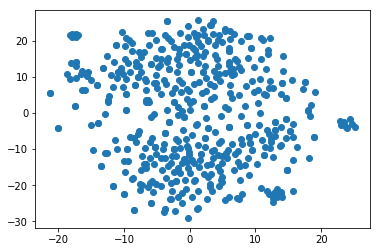

In [18]:
import matplotlib.pyplot as plt
plt.scatter(vecs_tsne[:, 0], vecs_tsne[:, 1])

In [205]:
vecs_combined = list(zip(vecs_tsne, map(lambda x: x.get_parent().text, cands)))
cand1 = vecs_combined[0]
print("Candidate sentence:")
print(cand1[1])
print()
vec_dists_to_cand1 = list(map(lambda x: np.sqrt((cand1[0][0] - x[0][0])**2 + (cand1[0][1] - x[0][1])**2), vecs_combined))
vec_dists_comb = zip(vec_dists_to_cand1, [v[1] for v in vecs_combined])
print("Most distant sentences:")
most_distant = sorted(vec_dists_comb, key=lambda x: x[0], reverse=True)[:5]
for dist, sent in most_distant:
    print("{} {}".format(sent, round(dist, 2)))

Candidate sentence:
Rifkind was nominated by President Franklin D. Roosevelt on April 25, 1941, to become a Federal District Court judge for the United States District Court for the Southern District of New York, filling the seat vacated by Robert P. Patterson, Sr..

Most distant sentences:
Peter Griffen (born 1948 Adelaide) is an Australian abstract artist.
 33.28
Man Singh, (died 1955) known as ``Daku Man Singh'', meaning Dacoit Maan Singh, was a notorious dacoit, or bandit, born in Agra to a Rajput Family.
 33.22
Michener was born near Attica in Seneca County, Ohio. 33.0
Lawrence Walford (born 20 January 1972 London) an award winning British television director. 32.73
Kieffer was born near Miami, Saline County, Missouri. 32.61


## Labeling functions

In [20]:
from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text,
)

# Function to get candidates labeled
def get_labeled_candidates(lf, split=0, n=500):
    labeled = []
    for c in session.query(PlaceOfBirth).filter(PlaceOfBirth.split == split).limit(n).all():
        if lf(c) != 0:
            labeled.append(c)
    return labeled

/Users/jayelm/.virtualenvs/snorkel/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


First, let's try an easy labeling function: checking to see if the world *born* exists between the person and the place. We'll do the same for the word *from*

In [21]:
def LF_born_between(c):
    return 1 if 'born' in get_between_tokens(c) else 0

def LF_from_between(c):
    return 1 if 'from' in get_between_tokens(c) else 0

labeled = get_labeled_candidates(LF_born_between, split=0)
SentenceNgramViewer(labeled, session, n_per_page=1)

<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[117]], [[105]], [[31]], [[68]], [[103]], [[53]], [[90]], [[181]], [[100]], [[182]], [[140]], [[119]], [[51]], [[66]], [[165]], [[93]], [[158]], [[83]], [[10, 11, 12]], [[59]], [[159]], [[84]], [[58]], [[168]], [[178]], [[188]], [[74]], [[15]], [[183]], [[1]], [[99]], [[101]], [[128]], [[149]], [[191]], [[186]], [[174]], [[120]], [[195]], [[27]], [[24]], [[5]], [[163]], [[107]], [[91]], [[34]], [[153]], [[50]], [[176]], [[136]], [[72]], [[111]], [[194]], [[94]], [[166]], [[143]], [[139]], [[80]], [[135]], [[73]], [[48]], [[132]], [[106]], [[124]], [[32]], [[65]], [[98]], [[122]], [[108]], [[137]], [[41]], [[17]], [[164]], [[142]], [[76, 77]], [[169]], [[47]], [[69]], [[19, 20]], [[156]], [[115]], [[49]], [[180]], [[92]], [[116]], [[152]], [[85]], [[16]], [[193]], [[29]], [[28]], [[18]], [[157]], [[133]], [[170]], [[22]], [[160]], [[130]], [[35]], [[175]], [[102]], [[2]], [[42]], [[134]], [[189]], [[81]], [[38]], [[88]], [[171]], [[184]], [[39]], [[151]], [[46]], [[121]], [[126]], [[185]], [[187]], [[30]], [[62]], [[173]], [[125]], [[26]], [[148]], [[37]], [[127]], [[55]], [[70]], [[14]], [[167]], [[67]], [[138]], [[43]], [[36]], [[8]], [[97]], [[150]], [[95, 96]], [[63]], [[52]], [[13]], [[177]], [[3]], [[82]], [[104]], [[145]], [[21]], [[87]], [[112, 113]], [[118]], [[146]], [[154]], [[7]], [[64]], [[78]], [[44, 45]], [[147]], [[109]], [[89]], [[162]], [[33]], [[75]], [[144]], [[9]], [[40]], [[60]], [[172]], [[179]], [[155]], [[131]], [[129]], [[61]], [[0]], [[161]], [[71]], [[56]], [[6]], [[4]], [[114]], [[79]], [[110]], [[190]], [[192]], [[54]], [[23]], [[123]], [[57]], [[86]], [[141]], [[25]]], html='<head>\n<style>\nspan.candidate {\n    background-color: rgba(255,255,0,0.3);\n}\n\nspan.candidate-h {\n    background-color: rgba(255,255,0,1.0);\n}\n\nspan.true-candidate {\n    background-color: rgba(92,184,92,0.3);\n}\n\nspan.true-candidate-h {\n    background-color: rgba(92,184,92,1.0);\n}\n\nspan.false-candidate {\n    background-color: rgba(169,68,66,0.3);\n}\n\nspan.false-candidate-h {\n    background-color: rgba(169,68,66,1.0);\n}\n\nspan.highlighted {\n    font-weight: bolder;\n    box-shadow: 1px 1px 1px grey;\n}\n\nspan.left-candidate {\n    color: red;\n}\n\nspan.right-candidate {\n    color: blue;\n}\n\nspan.gold-annotation {\n    color: red;\n}\n\nspan.highlighted-gold-annotation {\n    background-color: rgba(217,83,79,0.5);\n}\n\n.panel-heading {\n    position: relative;\n}\n\n.panel-footer {\n    position: relative;\n}\n\n.panel-left-justify {\n    position: absolute;\n    right: 15px;\n    top: 20px;\n}\n\n.viewer-page {\n    display: none;\n}\n\n.help-text {\n    color: gray;\n    font-weight: 300;\n}\n</style>\n</head>\n\n<div id="viewer" class="viewer-pane panel panel-default" tabindex="0">\n    <div class="panel-heading">\n        <h3 class="panel-title"><i class="fa fa-eye fa-lg" aria-hidden="true"></i> Viewer</h3>\n        <div id="candidate-caption" class="panel-left-justify"></div>\n    </div>\n    <div class="panel-body" style="height:225px">\n<div class="viewer-page" id="viewer-page-0" style="display: block;">\n    <ul class="list-group">\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="11684"><span class="candidate 117 117-0">Lezana</span><span class=""> was born at </span><span class="candidate 117 117-1">Madrid</span><span class="">.</span></li>\n</ul>\n</div>\n\n<div class="viewer-page" id="viewer-page-1">\n    <ul class="list-group">\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="11816"><span class="candidate 105 105-0">Mark Robinson</span><span class=""> (born November 21, 1968) is a footballer born in </span><span class="candidate 105 105-1">Rochdale</span><span class="">, Lancashire.</span></li>\n</ul>\n</div>\n\n<div class="viewer-page" id="viewer-page-2">\n    <ul class="list-group">\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="11848"><span class="candidate 31 31-0">Ma

After viewing NGrams, it's clear that since the location tagger tags cities and states, both are labeled. However, in our dataset, we generally prefer the most specific location, so we write additional labeling functions that return False if there is another location closer to the person

In [22]:
def span_is_pob(span):
    return bool(span.place_of_birth_pobs)

def span_is_person(span):
    return bool(span.place_of_birth_persons)

def span_distance(s1, s2):
    s1_start, s1_end = s1.get_word_start(), s1.get_word_end()
    s2_start, s2_end = s2.get_word_start(), s2.get_word_end()
    if s2_start < s1_start:
        return s1_start - s2_end
    else:
        return s2_start - s1_end

# TODO: Don't count less-specific substrings e.g. killing "Washington D.C." in favor of "Washington"
# TODO: Need to account for object hierarchy here...basically change locs to cities/etc.
def LF_closer_pob(c):
    # Get distance between person and pob
    cand_distance = span_distance(c.person, c.pob)
    sent = c.get_parent()
    other_pobs = [span for span in sent.get_children()
                  if (span != c.person) and (span != c.pob) and (span_is_pob(span))]
    for other_pob in other_pobs:
        if span_distance(c.person, other_pob) < cand_distance:
            return -1
    return 0

def LF_closer_person(c):
    # Get distance between person and pob
    cand_distance = span_distance(c.person, c.pob)
    sent = c.get_parent()
    other_persons = [span for span in sent.get_children()
                     if (span != c.person) and (span != c.pob) and (span_is_person(span))]
    for other_person in other_persons:
        if span_distance(c.pob, other_person) < cand_distance:
            return -1
    return 0

labeled = get_labeled_candidates(LF_closer_pob, split=0)
SentenceNgramViewer(labeled, session, n_per_page=1)

<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[31]], [[139, 164]], [[36]], [[52, 128]], [[82]], [[138]], [[95]], [[80, 81]], [[178]], [[4, 5]], [[56]], [[60]], [[73]], [[38]], [[110, 167]], [[177]], [[78]], [[168]], [[84]], [[114]], [[135]], [[85]], [[161, 162]], [[152]], [[8]], [[57]], [[32]], [[54]], [[129]], [[18]], [[39]], [[142]], [[33]], [[123, 130]], [[48]], [[22]], [[30]], [[159]], [[133]], [[69, 97]], [[58]], [[13, 175]], [[83]], [[87]], [[24, 25]], [[134]], [[42]], [[155]], [[101, 148]], [[6]], [[149]], [[153]], [[171]], [[88]], [[28]], [[151]], [[2]], [[10]], [[131, 132]], [[115]], [[9]], [[92]], [[146]], [[55]], [[45]], [[137, 145]], [[120]], [[44]], [[37]], [[0]], [[172]], [[21]], [[1]], [[14]], [[93]], [[86]], [[46]], [[127]], [[68]], [[17]], [[173, 174, 179]], [[61]], [[72]], [[106]], [[63]], [[64]], [[104, 158]], [[154]], [[49, 70, 169]], [[105]], [[100]], [[41]], [[140, 141]], [[74]], [[119]], [[43]], [[118]], [[75]], [[156]], [[76, 112]], [[59]], [[107]], [[102, 150, 166, 170, 176, 180]], [[122, 163]], [[34]], [[12]], [[65]], [[124]], [[77]], [[51]], [[96]], [[7]], [[29]], [[40]], [[160]], [[15]], [[89]], [[116]], [[11]], [[111, 125]], [[66, 136]], [[79]], [[94]], [[50]], [[3, 71]], [[113]], [[121]], [[20]], [[19]], [[90, 91]], [[98]], [[103]], [[157]], [[26]], [[109]], [[144]], [[47]], [[165]], [[16]], [[143]], [[99]], [[108]], [[62]], [[35]], [[147]], [[67]], [[53]], [[23]], [[27]], [[117, 126]]], html='<head>\n<style>\nspan.candidate {\n    background-color: rgba(255,255,0,0.3);\n}\n\nspan.candidate-h {\n    background-color: rgba(255,255,0,1.0);\n}\n\nspan.true-candidate {\n    background-color: rgba(92,184,92,0.3);\n}\n\nspan.true-candidate-h {\n    background-color: rgba(92,184,92,1.0);\n}\n\nspan.false-candidate {\n    background-color: rgba(169,68,66,0.3);\n}\n\nspan.false-candidate-h {\n    background-color: rgba(169,68,66,1.0);\n}\n\nspan.highlighted {\n    font-weight: bolder;\n    box-shadow: 1px 1px 1px grey;\n}\n\nspan.left-candidate {\n    color: red;\n}\n\nspan.right-candidate {\n    color: blue;\n}\n\nspan.gold-annotation {\n    color: red;\n}\n\nspan.highlighted-gold-annotation {\n    background-color: rgba(217,83,79,0.5);\n}\n\n.panel-heading {\n    position: relative;\n}\n\n.panel-footer {\n    position: relative;\n}\n\n.panel-left-justify {\n    position: absolute;\n    right: 15px;\n    top: 20px;\n}\n\n.viewer-page {\n    display: none;\n}\n\n.help-text {\n    color: gray;\n    font-weight: 300;\n}\n</style>\n</head>\n\n<div id="viewer" class="viewer-pane panel panel-default" tabindex="0">\n    <div class="panel-heading">\n        <h3 class="panel-title"><i class="fa fa-eye fa-lg" aria-hidden="true"></i> Viewer</h3>\n        <div id="candidate-caption" class="panel-left-justify"></div>\n    </div>\n    <div class="panel-body" style="height:225px">\n<div class="viewer-page" id="viewer-page-0" style="display: block;">\n    <ul class="list-group">\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="12181"><span class="candidate 31 31-0">David Paton</span><span class=""> was born at Hamilton, South Lanarkshire, </span><span class="candidate 31 31-1">Scotland</span><span class="">, on the 30 July 1912 and was educated at the Hamilton Academy, a prestigious Scottish school that featured in the Scottish Secondary Teachers`` Association 1950 magazine article series \'\'Famous Scottish Schools.</span></li>\n</ul>\n</div>\n\n<div class="viewer-page" id="viewer-page-1">\n    <ul class="list-group">\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="12222"><span class="">Finney was born at </span><span class="candidate 164 164-1">Wilmslow</span><span class="">, Cheshire, 13 February 1718-19, was eldest son of </span><span class="candidate 139 139-0">Samuel Finney</span><span class=""> of Fulshaw, Cheshire, and Esther, daughter of </span><span class="candidate 164 164-0">Ralph Davenport</span><span class=""> of </span><span class="candidate 139 139-1">Chorley</spa

We can also compose LFs together. Examples like

> Jack Curtner (9 July 1888 Greenville, Ohio -- 1 January 1961 Dayton, Ohio) was an American racecar driver.

suggest that some sentences in our dataset contain `born location -- death location` information immediately following a name. We can use parentheses as an explicit supervision signal. Specifically, if a `pob` is the leftmost `pob` in parentheses immediately following the person name, we vote yes.

In [23]:
def close_paren_right(c, window=20):
    """
    Simple heuristic for checking close parentheses.
    Note, doesn't account for nested parens
    """
    for token in get_right_tokens(c, window=window):
        if token == '(':
            return False
        if token == ')':
            return True
    return False

def open_paren_left(c, window=20):
    for token in list(get_left_tokens(c, window=window))[::-1]:
        if token == ')':
            return False
        if token == '(':
            return True
    return False

def surrounded_parens(c, window=20):
    return close_paren_right(c, window=window) and open_paren_left(c, window=window)

def paren_imm_right(c):
    """Is there a left paren immediately right of the person?"""
    try:
        return next(get_right_tokens(c, window=1)) == '('
    except StopIteration:
        return False

def right_paren_index(c):
    return c.get_word_end() + 1

def left_paren_index(c, window=20):
    """Get the left paren index found by open_paren_left. Assumes open_paren_left returns True!"""
    for i, token in enumerate(list(get_left_tokens(c, window=window))[::-1]):
        if token == '(':
            return c.get_word_start() - (i + 1)
    raise RuntimeError("No left paren found")

def LF_leftmost_pob_in_parens(c):
    if not LF_closer_pob(c) and surrounded_parens(c.pob) and \
            paren_imm_right(c.person) and right_paren_index(c.person) == left_paren_index(c.pob):
        return 1
    return 0

labeled = get_labeled_candidates(LF_leftmost_pob_in_parens, split=0)
SentenceNgramViewer(labeled, session, n_per_page=1)

<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[71]], [[83]], [[84]], [[24]], [[11]], [[42]], [[29]], [[86]], [[32]], [[36]], [[46]], [[9]], [[79]], [[81]], [[3]], [[47]], [[61]], [[76]], [[56]], [[48]], [[17]], [[50]], [[80]], [[51]], [[35]], [[28]], [[2]], [[67]], [[65]], [[63]], [[15]], [[57]], [[49]], [[21]], [[12]], [[27]], [[34]], [[41]], [[73]], [[53]], [[60]], [[23]], [[54]], [[72]], [[10]], [[13]], [[75]], [[74]], [[4]], [[78]], [[85]], [[64]], [[39]], [[19]], [[16]], [[66]], [[43]], [[70]], [[0]], [[59]], [[52]], [[1]], [[30]], [[77]], [[55]], [[45]], [[14]], [[69]], [[33]], [[22]], [[18]], [[44]], [[25]], [[8]], [[5]], [[7]], [[31]], [[37]], [[20]], [[82]], [[62]], [[68]], [[6]], [[38]], [[26]], [[58]], [[40]]], html='<head>\n<style>\nspan.candidate {\n    background-color: rgba(255,255,0,0.3);\n}\n\nspan.candidate-h {\n    background-color: rgba(255,255,0,1.0);\n}\n\nspan.true-candidate {\n    background-color: rgba(92,184,92,0.3);\n}\n\nspan.true-candidate-h {\n    background-color: rgba(92,184,92,1.0);\n}\n\nspan.false-candidate {\n    background-color: rgba(169,68,66,0.3);\n}\n\nspan.false-candidate-h {\n    background-color: rgba(169,68,66,1.0);\n}\n\nspan.highlighted {\n    font-weight: bolder;\n    box-shadow: 1px 1px 1px grey;\n}\n\nspan.left-candidate {\n    color: red;\n}\n\nspan.right-candidate {\n    color: blue;\n}\n\nspan.gold-annotation {\n    color: red;\n}\n\nspan.highlighted-gold-annotation {\n    background-color: rgba(217,83,79,0.5);\n}\n\n.panel-heading {\n    position: relative;\n}\n\n.panel-footer {\n    position: relative;\n}\n\n.panel-left-justify {\n    position: absolute;\n    right: 15px;\n    top: 20px;\n}\n\n.viewer-page {\n    display: none;\n}\n\n.help-text {\n    color: gray;\n    font-weight: 300;\n}\n</style>\n</head>\n\n<div id="viewer" class="viewer-pane panel panel-default" tabindex="0">\n    <div class="panel-heading">\n        <h3 class="panel-title"><i class="fa fa-eye fa-lg" aria-hidden="true"></i> Viewer</h3>\n        <div id="candidate-caption" class="panel-left-justify"></div>\n    </div>\n    <div class="panel-body" style="height:225px">\n<div class="viewer-page" id="viewer-page-0" style="display: block;">\n    <ul class="list-group">\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="11883"><span class="candidate 71 71-0">Lars Gabriel von Haartman</span><span class=""> (23 September 1789 </span><span class="candidate 71 71-1">Turku</span><span class=""> - 16 December 1859 Merimasku) was a Swedish-speaking Finnish politician.</span></li>\n</ul>\n</div>\n\n<div class="viewer-page" id="viewer-page-1">\n    <ul class="list-group">\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="12258"><span class="candidate 83 83-0">Magdaléna Hajóssyová</span><span class=""> (born 25 July 1946, </span><span class="candidate 83 83-1">Bratislava</span><span class="">) is a renowned classical Slovak soprano who has had an active international career singing in operas, concerts, and recitals since the late 1960s.</span></li>\n</ul>\n</div>\n\n<div class="viewer-page" id="viewer-page-2">\n    <ul class="list-group">\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="12655"><span class="candidate 84 84-0">Elizabeth Kell</span><span class=""> (born 09 July 1983 in </span><span class="candidate 84 84-1">Sydney</span><span class="">) is an Australian rower.\n</span></li>\n</ul>\n</div>\n\n<div class="viewer-page" id="viewer-page-3">\n    <ul class="list-group">\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="13826"><span class="candidate 24 24-0">Abel Dimier</span><span class=""> (born in 1794 in </span><span class="candidate 24 24-1">Paris</span><span class="">, died in 1864) was a French sculptor.\n</span></li>\n</ul>\n</div>\n\n<div class="viewer-page" id="viewer-page-4">\n    <ul class="list-group">\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="14577"><span class="ca

This LF checks if words indicating death exist, and votes no if so

In [24]:
death_words = {'died', 'death', 'passing', 'passed'}
def LF_death_between(c):
    return -1 if len(set.intersection(death_words, get_between_tokens(c))) > 0 else 0

labeled = get_labeled_candidates(LF_death_between, split=0)
SentenceNgramViewer(labeled, session, n_per_page=1)

<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[32]], [[12]], [[19]], [[17]], [[3]], [[1]], [[20]], [[27]], [[4]], [[30]], [[11]], [[23]], [[25]], [[16]], [[26]], [[9]], [[29]], [[24]], [[18]], [[28]], [[7]], [[21]], [[6]], [[10]], [[2]], [[33]], [[22]], [[8]], [[0]], [[5]], [[13, 14]], [[15]], [[31]]], html='<head>\n<style>\nspan.candidate {\n    background-color: rgba(255,255,0,0.3);\n}\n\nspan.candidate-h {\n    background-color: rgba(255,255,0,1.0);\n}\n\nspan.true-candidate {\n    background-color: rgba(92,184,92,0.3);\n}\n\nspan.true-candidate-h {\n    background-color: rgba(92,184,92,1.0);\n}\n\nspan.false-candidate {\n    background-color: rgba(169,68,66,0.3);\n}\n\nspan.false-candidate-h {\n    background-color: rgba(169,68,66,1.0);\n}\n\nspan.highlighted {\n    font-weight: bolder;\n    box-shadow: 1px 1px 1px grey;\n}\n\nspan.left-candidate {\n    color: red;\n}\n\nspan.right-candidate {\n    color: blue;\n}\n\nspan.gold-annotation {\n    color: red;\n}\n\nspan.highlighted-gold-annotation {\n    background-color: rgba(217,83,79,0.5);\n}\n\n.panel-heading {\n    position: relative;\n}\n\n.panel-footer {\n    position: relative;\n}\n\n.panel-left-justify {\n    position: absolute;\n    right: 15px;\n    top: 20px;\n}\n\n.viewer-page {\n    display: none;\n}\n\n.help-text {\n    color: gray;\n    font-weight: 300;\n}\n</style>\n</head>\n\n<div id="viewer" class="viewer-pane panel panel-default" tabindex="0">\n    <div class="panel-heading">\n        <h3 class="panel-title"><i class="fa fa-eye fa-lg" aria-hidden="true"></i> Viewer</h3>\n        <div id="candidate-caption" class="panel-left-justify"></div>\n    </div>\n    <div class="panel-body" style="height:225px">\n<div class="viewer-page" id="viewer-page-0" style="display: block;">\n    <ul class="list-group">\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="15348"><span class="">Luigi Canina, Italian architect and archeologist, was born in </span><span class="candidate 32 32-0">Casale Monferrato</span><span class=""> in 1795 and died in </span><span class="candidate 32 32-1">Florence</span><span class=""> in 1856.</span></li>\n</ul>\n</div>\n\n<div class="viewer-page" id="viewer-page-1">\n    <ul class="list-group">\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="20061"><span class="candidate 12 12-0">William Clarke</span><span class=""> (born 24 December 1798 at Nottingham; died 25 August 1856 at Wandsworth, </span><span class="candidate 12 12-1">Surrey</span><span class="">) was an English cricketer and team manager who played first-class cricket from 1826 to 1855.</span></li>\n</ul>\n</div>\n\n<div class="viewer-page" id="viewer-page-2">\n    <ul class="list-group">\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="29887"><span class="candidate 19 19-0">Man Singh</span><span class="">, (died 1955) known as ``Daku </span><span class="candidate 19 19-1">Man</span><span class=""> Singh\'\', meaning Dacoit Maan Singh, was a notorious dacoit, or bandit, born in Agra to a Rajput Family.\n</span></li>\n</ul>\n</div>\n\n<div class="viewer-page" id="viewer-page-3">\n    <ul class="list-group">\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="30385"><span class="candidate 17 17-0">Griffith</span><span class="">\'s death was the second in a string of three infamous racially motivated killings of blacks by white mobs in </span><span class="candidate 17 17-1">New York City</span><span class=""> in the 1980s.</span></li>\n</ul>\n</div>\n\n<div class="viewer-page" id="viewer-page-4">\n    <ul class="list-group">\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="42523"><span class="candidate 3 3-0">George Maddox</span><span class=""> died on 7 July 1867 in </span><span class="candidate 3 3-1">Melbourne</span><span class="">, Victoria at the age of 56.\n</span></li>\n</ul>\n</div>\n\n<div class="viewer-page" id="viewer-page-5">\n    <ul class="list-gro

LFs for model 2 only

In [134]:
bad_prepositions = {'for', 'towards', 'to', 'outside', 'inside'}
def LF_pob_bad_preposition(c):
    try:
        token_left_pob = list(get_left_tokens(c.pob, window=1))[0]
        return -1 if token_left_pob in bad_prepositions else 0
    except IndexError:
        return 0

def LF_born_before_person(c):
    if c.pob.get_word_start() > c.person.get_word_start():
        return 0
    left_two_tokens = list(get_left_tokens(c.pob, window=2))
    try:
        left_of_person = list(get_left_tokens(c.person, window=1))[0]
    except IndexError:
        return 0
    if left_of_person != ',':
        return 0
    if len(left_two_tokens) != 2:
        return 0
    return 1 if len(list(get_between_tokens(c))) < 4 and (
        left_two_tokens == ['born', 'in'] or
        left_two_tokens == ['native', 'of'] or
        left_two_tokens == ['born', 'at'] or
        left_two_tokens[-1] == 'from'
    ) else 0

def LF_closer_pob_2(c):
    # Abstain when pob is to the left of the person
    # if c.pob.get_word_start() < c.person.get_word_start():
    #     return 0
    # Get distance between person and pob
    cand_distance = span_distance(c.person, c.pob)
    sent = c.get_parent()
    other_pobs = [span for span in sent.get_children()
                  if (span != c.person) and (span != c.pob) and (span_is_pob(span))]
    for other_pob in other_pobs:
        if (span_distance(c.person, other_pob) - cand_distance < -2 and
            # Make sure the pob is not just overlapping with the person
            not (c.person.get_word_start() <= other_pob.get_word_start() <= c.person.get_word_end()) and
            other_pob.get_word_start() < c.pob.get_word_start()):
            return -1
    return 0

labeled = get_labeled_candidates(LF_closer_pob_2, split=0)
SentenceNgramViewer(labeled, session)

<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[20], [66], [35]], [[52], [3], [41]], [[49], [25], [59]], [[38], [21], [36]], [[65], [11], [26]], [[22], [15], [73]], [[46], [39], [17, 18]], [[54, 69], [4], [71]], [[2], [7], [6]], [[68], [37], [30]], [[29], [24], [0]], [[14], [1], [8]], [[10], [42], [48]], [[58], [44], [45]], [[56, 72], [32, 47], [57]], [[27], [67], [28]], [[63], [50], [40]], [[55, 70], [51], [34]], [[5], [60], [33]], [[61], [13], [12]], [[53], [19], [31]], [[74], [9], [43]], [[23], [16], [62, 64]]], html='<head>\n<style>\nspan.candidate {\n    background-color: rgba(255,255,0,0.3);\n}\n\nspan.candidate-h {\n    background-color: rgba(255,255,0,1.0);\n}\n\nspan.true-candidate {\n    background-color: rgba(92,184,92,0.3);\n}\n\nspan.true-candidate-h {\n    background-color: rgba(92,184,92,1.0);\n}\n\nspan.false-candidate {\n    background-color: rgba(169,68,66,0.3);\n}\n\nspan.false-candidate-h {\n    background-color: rgba(169,68,66,1.0);\n}\n\nspan.highlighted {\n    font-weight: bolder;\n    box-shadow: 1px 1px 1px grey;\n}\n\nspan.left-candidate {\n    color: red;\n}\n\nspan.right-candidate {\n    color: blue;\n}\n\nspan.gold-annotation {\n    color: red;\n}\n\nspan.highlighted-gold-annotation {\n    background-color: rgba(217,83,79,0.5);\n}\n\n.panel-heading {\n    position: relative;\n}\n\n.panel-footer {\n    position: relative;\n}\n\n.panel-left-justify {\n    position: absolute;\n    right: 15px;\n    top: 20px;\n}\n\n.viewer-page {\n    display: none;\n}\n\n.help-text {\n    color: gray;\n    font-weight: 300;\n}\n</style>\n</head>\n\n<div id="viewer" class="viewer-pane panel panel-default" tabindex="0">\n    <div class="panel-heading">\n        <h3 class="panel-title"><i class="fa fa-eye fa-lg" aria-hidden="true"></i> Viewer</h3>\n        <div id="candidate-caption" class="panel-left-justify"></div>\n    </div>\n    <div class="panel-body" style="height:225px">\n<div class="viewer-page" id="viewer-page-0" style="display: block;">\n    <ul class="list-group">\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="12181"><span class="candidate 20 20-0">David Paton</span><span class=""> was born at Hamilton, South Lanarkshire, </span><span class="candidate 20 20-1">Scotland</span><span class="">, on the 30 July 1912 and was educated at the Hamilton Academy, a prestigious Scottish school that featured in the Scottish Secondary Teachers`` Association 1950 magazine article series \'\'Famous Scottish Schools.</span></li>\n\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="12222"><span class="">Finney was born at Wilmslow, Cheshire, 13 February 1718-19, was eldest son of </span><span class="candidate 66 66-0">Samuel Finney</span><span class=""> of Fulshaw, Cheshire, and Esther, daughter of Ralph Davenport of </span><span class="candidate 66 66-1">Chorley</span><span class="">.</span></li>\n\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="12427"><span class="candidate 35 35-0">John Littleton</span><span class=""> is the son of glass artist Harvey Littleton and his wife, Bess Tamura </span><span class="candidate 35 35-1">Littleton</span><span class="">.</span></li>\n</ul>\n</div>\n\n<div class="viewer-page" id="viewer-page-1">\n    <ul class="list-group">\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="14209"><span class="">Born in Addison, New York, </span><span class="candidate 52 52-0">Gillet</span><span class=""> attended the public schools and the Delaware Literary Institute, </span><span class="candidate 52 52-1">Franklin</span><span class="">, New York.</span></li>\n\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="14465"><span class="candidate 3 3-0">Strallen</span><span class="">, who was born in London, England, had previously played that role twice in the West End production: she first joined the show at the end of 2005 to replace original cast member Laura Michelle Kelly, but l

`LFS_model1`: Labeling Functions used in Generative Model 1. `LFS_model2`: LFs used after improving/refining labeling functions upon inspecting Model 1 performance on dev set.

In [135]:
LFs_model1 = [
    LF_born_between, LF_from_between,
    LF_closer_pob,
    LF_death_between,
    LF_leftmost_pob_in_parens
]
LFs_model2 = [
    LF_born_between, LF_from_between,
    LF_closer_pob_2,
    LF_pob_bad_preposition,
    LF_born_before_person,
    LF_death_between,
    LF_leftmost_pob_in_parens
]

## Applying labeling functions

In [136]:
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(lfs=LFs_model2)

In [137]:
%time L_train = labeler.apply(split=0)
L_train

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 1min 18s, sys: 1.69 s, total: 1min 19s
Wall time: 1min 23s


<5259x7 sparse matrix of type '<class 'numpy.int64'>'
	with 4997 stored elements in Compressed Sparse Row format>

In [138]:
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
LF_born_between,0,0.440768,0.209926,0.056855
LF_from_between,1,0.038981,0.024720,0.023769
LF_closer_pob_2,2,0.135387,0.075870,0.067693
LF_pob_bad_preposition,3,0.018445,0.006845,0.003423
LF_born_before_person,4,0.052101,0.000000,0.000000
LF_death_between,5,0.061609,0.016923,0.011789
LF_leftmost_pob_in_parens,6,0.202890,0.152500,0.000380


## Generative Model

In [139]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
gen_model.train(L_train, epochs=100, decay=0.95, step_size=0.1 / L_train.shape[0], reg_param=1e-6)

Inferred cardinality: 2


### Interpretation

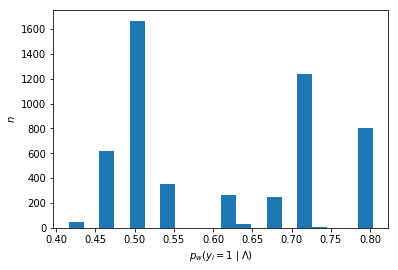

In [152]:
train_marginals = gen_model.marginals(L_train)
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.ylabel('$n$')
plt.xlabel('$p_w(y_i = 1 \mid \Lambda)$')
plt.show()

In [141]:
gen_model.learned_lf_stats()

,Accuracy,Coverage,Precision,Recall
0,0.713682,0.6863,0.711610,0.493408
1,0.548125,0.6639,0.553313,0.366960
2,0.535082,0.6556,0.537155,0.353775
3,0.547716,0.6633,0.545673,0.362765
4,0.552437,0.6627,0.557616,0.366360
5,0.554454,0.6758,0.556822,0.380743
6,0.622764,0.6765,0.624002,0.421694


## Evaluating LFs and generative model on dev set

In [142]:
from snorkel.annotations import load_gold_labels

L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
L_dev = labeler.apply_existing(split=1)

Clearing existing...
Running UDF...
[========================================] 100%



In [143]:
L_dev

<657x7 sparse matrix of type '<class 'numpy.int64'>'
	with 777 stored elements in Compressed Sparse Row format>

In [144]:
L_gold_dev

<657x1 sparse matrix of type '<class 'numpy.int64'>'
	with 657 stored elements in Compressed Sparse Row format>

In [145]:
tp, fp, tn, fn = gen_model.error_analysis(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.939
Neg. class accuracy: 0.553
Precision            0.849
Recall               0.939
F1                   0.892
----------------------------------------
TP: 449 | FP: 80 | TN: 99 | FN: 29



In [146]:
L_dev.lf_stats(session, L_gold_dev, gen_model.learned_lf_stats()['Accuracy'])

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_born_between,0,0.637747,0.289193,0.041096,360,59,0,0,0.859189,0.709829
LF_from_between,1,0.003044,0.003044,0.001522,1,1,0,0,0.500000,0.536158
LF_closer_pob_2,2,0.066971,0.045662,0.042618,0,0,20,24,0.545455,0.528784
LF_pob_bad_preposition,3,0.006088,0.000000,0.000000,0,0,0,4,1.000000,0.541332
LF_born_before_person,4,0.091324,0.000000,0.000000,46,14,0,0,0.766667,0.545961
LF_death_between,5,0.056317,0.004566,0.001522,0,0,0,37,1.000000,0.540476
LF_leftmost_pob_in_parens,6,0.321157,0.246575,0.000000,198,13,0,0,0.938389,0.627811


## Improving LFs

### Visualizing Errors

...for now, those made by `LF_closer_pob`, which does quite poorly

In [132]:
from snorkel.lf_helpers import test_LF
tp, fp, tn, fn = test_LF(session, LF_closer_pob, split=1, annotator_name='gold')
SentenceNgramViewer(fn, session)

Scores (Un-adjusted)
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 24 | FN: 20



<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[3], [6], [16]], [[7], [10], [15]], [[1], [2], [13]], [[8], [12], [9]], [[5], [19], [0]], [[4], [18], [14]], [[17], [11]]], html='<head>\n<style>\nspan.candidate {\n    background-color: rgba(255,255,0,0.3);\n}\n\nspan.candidate-h {\n    background-color: rgba(255,255,0,1.0);\n}\n\nspan.true-candidate {\n    background-color: rgba(92,184,92,0.3);\n}\n\nspan.true-candidate-h {\n    background-color: rgba(92,184,92,1.0);\n}\n\nspan.false-candidate {\n    background-color: rgba(169,68,66,0.3);\n}\n\nspan.false-candidate-h {\n    background-color: rgba(169,68,66,1.0);\n}\n\nspan.highlighted {\n    font-weight: bolder;\n    box-shadow: 1px 1px 1px grey;\n}\n\nspan.left-candidate {\n    color: red;\n}\n\nspan.right-candidate {\n    color: blue;\n}\n\nspan.gold-annotation {\n    color: red;\n}\n\nspan.highlighted-gold-annotation {\n    background-color: rgba(217,83,79,0.5);\n}\n\n.panel-heading {\n    position: relative;\n}\n\n.panel-footer {\n    position: relative;\n}\n\n.panel-left-justify {\n    position: absolute;\n    right: 15px;\n    top: 20px;\n}\n\n.viewer-page {\n    display: none;\n}\n\n.help-text {\n    color: gray;\n    font-weight: 300;\n}\n</style>\n</head>\n\n<div id="viewer" class="viewer-pane panel panel-default" tabindex="0">\n    <div class="panel-heading">\n        <h3 class="panel-title"><i class="fa fa-eye fa-lg" aria-hidden="true"></i> Viewer</h3>\n        <div id="candidate-caption" class="panel-left-justify"></div>\n    </div>\n    <div class="panel-body" style="height:225px">\n<div class="viewer-page" id="viewer-page-0" style="display: block;">\n    <ul class="list-group">\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="12565"><span class="candidate 3 3-0">Rufus Phillips</span><span class="">, Born in rural </span><span class="candidate 3 3-1">Virginia</span><span class=""> and educated at Yale, was a young C.I.A. officer in Saigon in the 1950s.</span></li>\n\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="14710"><span class="candidate 6 6-0">Asmahan Farhat</span><span class="">, or Mercedes Farhat, born May 1, 1990 in </span><span class="candidate 6 6-1">Strongsville</span><span class="">, Ohio, United States, is a Libyan swimmer.\n</span></li>\n\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="15206"><span class="candidate 16 16-0">Kazimierz Flatau</span><span class=""> (11 July 1910 in Warsaw -- 25 July 2000 in </span><span class="candidate 16 16-1">Poznań</span><span class="">) -- Polish harpsichordist, music critic, physicist, translator, and astrologist.</span></li>\n</ul>\n</div>\n\n<div class="viewer-page" id="viewer-page-1">\n    <ul class="list-group">\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="15611"><span class="candidate 7 7-0">Lidia Elsa Satragno</span><span class=""> was born in the western Buenos Aires suburb of </span><span class="candidate 7 7-1">San Justo</span><span class=""> in 1935.</span></li>\n\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="15665"><span class="candidate 10 10-0">Keena Rothhammer</span><span class=""> (born February 26, 1957 in Little Rock, </span><span class="candidate 10 10-1">Arkansas</span><span class="">) is a former freestyle swimmer from the United States.</span></li>\n\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="24098"><span class="candidate 15 15-0">Stallings</span><span class=""> was born Laurence Tucker Stallings in </span><span class="candidate 15 15-1">Macon</span><span class="">, Georgia to Larkin Tucker Stallings, a bank clerk, and Aurora Brooks Stallings, a homemaker and avid reader who inspired her son\'s love of literature.</span></li>\n</ul>\n</div>\n\n<div class="viewer-page" id="viewer-page-2">\n    <ul class="list-group">\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="24935"><span class="candidat

`LF_closer_pob_2` does better!

In [188]:
_ = test_LF(session, LF_closer_pob_2, split=1, annotator_name='gold')

Scores (Un-adjusted)
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 24 | FN: 20



### Increasing Coverage, Reducing Conflicts

First, viewing examples with no coverage:

In [58]:
no_coverage_ids = np.argwhere(np.array(((L_train != 0).sum(axis=1) == 0)).squeeze()).squeeze()
SentenceNgramViewer([L_train.get_candidate(session, i) for i in no_coverage_ids], session)

<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[112], [689], [233]], [[690], [20], [777]], [[702], [487], [210]], [[134], [712], [608]], [[94], [422], [823]], [[840], [311], [703]], [[163], [378], [212]], [[774], [82, 357], [341]], [[770], [168], [531]], [[142], [541], [122, 692]], [[278], [793], [652]], [[555], [629], [530]], [[565], [451], [53]], [[69], [730], [133]], [[671], [707], [668]], [[768], [698], [161]], [[460], [611], [508]], [[459], [800], [667]], [[138], [365], [209]], [[658], [198], [13]], [[164], [222], [691]], [[524], [647], [41]], [[51], [465], [842]], [[801], [352], [90]], [[421], [245], [185]], [[475], [455], [149]], [[506, 849], [407], [3]], [[4], [619], [577]], [[659], [83], [443]], [[266], [96], [845]], [[589, 719], [468], [319]], [[592], [195], [60]], [[117], [160], [605]], [[776], [385], [527]], [[313], [113], [474]], [[10], [177], [141]], [[350], [830], [727]], [[851], [61], [326]], [[305], [637], [832]], [[676], [19], [403]], [[772], [846], [764]], [[822], [711], [715]], [[493], [296], [299]], [[91], [25], [79]], [[518], [473], [187]], [[64], [159], [100]], [[315, 679], [490], [819]], [[638], [227], [33]], [[105], [624], [170]], [[328], [625], [749]], [[31], [48], [545, 673]], [[564], [575], [202]], [[613], [717], [275]], [[336], [12], [146]], [[664], [99], [308]], [[824], [108], [26]], [[166], [479], [50]], [[748], [631], [784]], [[597], [205], [42]], [[192], [226], [684]], [[466], [236], [686]], [[290], [310], [174]], [[622], [742], [735]], [[833], [380], [334]], [[438], [47], [11]], [[416], [810], [57]], [[43], [176], [353]], [[147], [705], [181]], [[375], [157], [283]], [[522], [364], [811]], [[788], [136], [649]], [[599], [333], [812]], [[729], [303], [284]], [[392], [839], [370]], [[606], [356], [484]], [[237], [740], [106]], [[238], [627], [251]], [[390], [435], [152]], [[501], [713], [292]], [[795], [362], [454]], [[540], [279], [738]], [[732], [124], [182]], [[648], [394], [685]], [[543], [214], [30]], [[23], [556], [230]], [[151], [306], [287]], [[39], [529], [763]], [[469], [89], [687]], [[376], [572], [391]], [[295], [419], [482]], [[109], [693], [836]], [[426], [709], [420]], [[213], [744], [322]], [[505], [241], [359]], [[7], [641], [298]], [[594], [337], [805]], [[417], [125], [49]], [[342], [248], [544]], [[258], [718], [791]], [[167], [371], [223]], [[173], [552, 825], [837]], [[224], [818], [615]], [[1], [513], [787, 829]], [[497], [503], [662]], [[144], [785], [780]], [[193], [8], [786]], [[571], [560], [368]], [[121], [491], [519, 630]], [[542], [208], [574]], [[533], [433], [621, 797]], [[115], [6], [746]], [[755], [462], [379]], [[346], [316], [655]], [[827], [329], [504]], [[646], [602], [582]], [[265], [107], [632]], [[411], [536], [412]], [[767], [35], [190]], [[424], [547], [440]], [[813], [563], [289]], [[92], [753], [554]], [[706], [769], [569]], [[410], [291], [633]], [[415], [80], [325]], [[116], [130], [234, 826]], [[747], [803], [363]], [[262], [728], [783]], [[512], [650], [814]], [[24], [452], [758]], [[835], [276], [696]], [[155], [179], [815]], [[688], [590], [515]], [[119], [710], [559]], [[665], [196], [792]], [[423], [743], [384]], [[472], [437], [221]], [[29], [154], [558]], [[439], [18], [101]], [[406], [150], [745]], [[820], [790], [806]], [[478], [137], [218]], [[189], [17], [156]], [[58], [68], [847]], [[171], [618], [802]], [[400], [580], [253]], [[568], [126], [110]], [[500], [84], [807]], [[669], [14], [682]], [[694], [450], [140]], [[681], [355], [27]], [[118], [52], [526]], [[361], [259], [704]], [[581], [15], [351]], [[808], [347], [270]], [[771], [321], [583]], [[725], [398], [591]], [[535], [678], [841]], [[600], [737], [162]], [[471], [103], [55]], [[343], [383], [576]], [[165], [470], [401, 402]], [[186], [761], [509]], [[697], [831], [158]], [[838], [586], [393]], [[587], [520], [723, 843]], [[752, 809], [268], [148]], [[612], [634], [853]], [[525], [588], [215]], [[366], [22], [280]], [[514], [172], [494]], [[252], [828], [607]], [[781], [620], [81]], [[240], [73],

Next, conflicting examples (resolving these was mentioned in the conclusion section, though I didn't get to this part):

In [147]:
conflict_ids = np.argwhere(np.apply_along_axis(lambda x: (-1 in x) and (1 in x), 1, L_train.toarray())).squeeze()
SentenceNgramViewer([L_train.get_candidate(session, i) for i in conflict_ids], session)

<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[333], [376], [342]], [[14], [99], [111]], [[203], [347], [269]], [[341], [78], [228]], [[367], [292], [129]], [[59], [314], [352]], [[101], [91], [67]], [[368], [277], [338]], [[164], [210], [166]], [[3], [199], [50]], [[365], [56], [32]], [[29], [33], [370]], [[226], [36], [160]], [[30], [345], [237]], [[165], [283], [161]], [[240], [102], [340]], [[128], [211], [198]], [[336], [217], [139]], [[47], [85], [191]], [[62], [187], [131]], [[121], [284], [248]], [[147], [142], [88]], [[163], [310], [103]], [[27], [53], [15]], [[190], [25], [362]], [[113], [9], [287]], [[170], [68], [37]], [[51], [16], [145]], [[222], [343], [238]], [[247], [256], [11]], [[118], [394], [146]], [[55], [72], [174]], [[216], [193], [76]], [[70], [225], [246]], [[355], [106], [135]], [[297], [213], [57]], [[387], [12, 13], [359]], [[321], [250], [183]], [[86], [220], [186]], [[4], [143], [109]], [[94], [97], [185]], [[245], [306], [159]], [[66], [125], [361]], [[45], [167], [377]], [[123], [96], [2]], [[201], [7], [52]], [[6], [286], [71]], [[31], [369], [48, 49, 351]], [[26], [21], [80]], [[268], [334], [274]], [[20], [46], [328]], [[300], [192], [309]], [[0], [271], [149]], [[1], [221], [316]], [[8], [105], [349]], [[232], [308], [43]], [[89, 90], [77], [119]], [[317], [92], [65]], [[291], [339], [158]], [[331], [173], [242]], [[212], [60], [93]], [[95], [357], [236]], [[383], [299], [379]], [[298], [266], [63]], [[54], [295], [302]], [[332, 378], [335], [154]], [[218], [61], [353]], [[281], [262], [384]], [[207], [177], [69]], [[19], [224], [157]], [[239], [112], [288]], [[38, 326], [285], [311]], [[319], [127], [312]], [[234], [322], [64]], [[290], [318], [82]], [[257, 385, 386, 388, 389, 390, 391, 392, 393], [28], [108]], [[259], [264], [155]], [[230], [176], [188]], [[84], [162], [273]], [[354], [348], [263]], [[315], [360], [227]], [[204], [249], [126]], [[272], [313], [320]], [[329], [130], [35]], [[24], [134], [5]], [[197], [208], [294]], [[371], [115], [289, 372]], [[122], [110], [293, 358]], [[73], [381], [307]], [[304, 305], [279], [152]], [[144], [261], [39]], [[323], [98], [124]], [[169], [151], [243]], [[253], [107], [141]], [[133], [23], [296]], [[276], [175], [10]], [[267], [74], [202]], [[209], [120], [42]], [[87], [137], [229]], [[206], [258], [184]], [[58], [171], [270]], [[282], [301], [337]], [[223], [330], [260]], [[231], [104], [200]], [[280], [83], [244]], [[233], [327], [79]], [[140], [22], [275]], [[172], [181], [194]], [[75], [156], [117]], [[373], [17], [138]], [[303], [148], [132]], [[324], [100], [356]], [[382], [81], [205]], [[178, 179, 180], [254, 255], [153]], [[241], [364], [195]], [[116], [363], [40, 41, 344]], [[150], [168], [265]], [[114], [219], [350]], [[325], [196], [18]], [[34], [278], [251, 252, 366, 374, 375]], [[136], [235], [44]], [[215], [182], [380]], [[189], [214], [346]]], html='<head>\n<style>\nspan.candidate {\n    background-color: rgba(255,255,0,0.3);\n}\n\nspan.candidate-h {\n    background-color: rgba(255,255,0,1.0);\n}\n\nspan.true-candidate {\n    background-color: rgba(92,184,92,0.3);\n}\n\nspan.true-candidate-h {\n    background-color: rgba(92,184,92,1.0);\n}\n\nspan.false-candidate {\n    background-color: rgba(169,68,66,0.3);\n}\n\nspan.false-candidate-h {\n    background-color: rgba(169,68,66,1.0);\n}\n\nspan.highlighted {\n    font-weight: bolder;\n    box-shadow: 1px 1px 1px grey;\n}\n\nspan.left-candidate {\n    color: red;\n}\n\nspan.right-candidate {\n    color: blue;\n}\n\nspan.gold-annotation {\n    color: red;\n}\n\nspan.highlighted-gold-annotation {\n    background-color: rgba(217,83,79,0.5);\n}\n\n.panel-heading {\n    position: relative;\n}\n\n.panel-footer {\n    position: relative;\n}\n\n.panel-left-justify {\n    position: absolute;\n    right: 15px;\n    top: 20px;\n}\n\n.viewer-page {\n    display: none;\n}\n\n.help-text {\n    color: gray;\n    font-weight: 300;\n}\n</style>\n</head>\n\n<div id="viewer" class="viewer-pane panel panel-default" tab

### Save noisy labels to database

In [148]:
from snorkel.annotations import save_marginals
%time save_marginals(session, L_train, train_marginals)

Saved 5259 marginals
CPU times: user 4.92 s, sys: 67.5 ms, total: 4.99 s
Wall time: 5.12 s


## Training an End Model

In [160]:
train_cands = session.query(PlaceOfBirth).filter(PlaceOfBirth.split == 0).all()
dev_cands   = session.query(PlaceOfBirth).filter(PlaceOfBirth.split == 1).all()
test_cands  = session.query(PlaceOfBirth).filter(PlaceOfBirth.split == 2).all()
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)

(5259,)

We have gold annotations for our train data, which we can also train on:

In [171]:
L_gold_train = load_gold_labels(session, annotator_name='gold', split=0)
# Convert to 1.0s, 0.0s
L_gold_train = (L_gold_train.toarray().squeeze() == 1) * 1.0

In [180]:
from snorkel.learning.disc_models.rnn import reRNN

train_kwargs = {
    'lr':         0.01,
    'dim':        50,
    'n_epochs':   100,
    'dropout':    0.25,
    'print_freq': 1,
    'max_sentence_length': 100
}

lstm = reRNN(seed=1701, n_threads=None)
lstm.train(train_cands, train_marginals, X_dev=dev_cands, Y_dev=L_gold_dev, **train_kwargs)

/Users/jayelm/Git/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 1080 has argument past max length for model:	[arg ends at index 155; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/Users/jayelm/Git/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 2249 has argument past max length for model:	[arg ends at index 114; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/Users/jayelm/Git/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 2253 has argument past max length for model:	[arg ends at index 124; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/Users/jayelm/Git/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 2254 has argument past max length for model:	[arg ends at index 124; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/Users/jayelm/Git/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: 

[reRNN] Training model
[reRNN] n_train=3681  #epochs=100  batch size=256
[reRNN] Epoch 0 (11.73s)	Average loss=0.654968	Dev F1=84.23
[reRNN] Epoch 1 (22.81s)	Average loss=0.627194	Dev F1=85.02
[reRNN] Epoch 2 (37.88s)	Average loss=0.619655	Dev F1=84.45
[reRNN] Epoch 3 (53.21s)	Average loss=0.616654	Dev F1=86.47
[reRNN] Epoch 4 (68.79s)	Average loss=0.615379	Dev F1=86.55
[reRNN] Epoch 5 (80.17s)	Average loss=0.614058	Dev F1=85.92
[reRNN] Epoch 6 (91.71s)	Average loss=0.613851	Dev F1=86.32
[reRNN] Epoch 7 (103.34s)	Average loss=0.612822	Dev F1=86.74
[reRNN] Epoch 8 (115.51s)	Average loss=0.612534	Dev F1=86.26
[reRNN] Epoch 9 (126.58s)	Average loss=0.613076	Dev F1=86.83
[reRNN] Epoch 10 (137.86s)	Average loss=0.612593	Dev F1=86.72
[reRNN] Epoch 11 (148.83s)	Average loss=0.612778	Dev F1=86.61
[reRNN] Epoch 12 (159.86s)	Average loss=0.612534	Dev F1=86.45
[reRNN] Epoch 13 (171.11s)	Average loss=0.612729	Dev F1=86.47
[reRNN] Epoch 14 (182.89s)	Average loss=0.611988	Dev F1=86.53
[reRNN] Epoch 

In [181]:
p, r, f1 = lstm.score(test_cands, L_gold_test)
print("Prec: {0:.3f}, Recall: {1:.3f}, F1 Score: {2:.3f}".format(p, r, f1))

Prec: 0.793, Recall: 0.983, F1 Score: 0.878


In [182]:
tp, fp, tn, fn = lstm.error_analysis(session, test_cands, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.983
Neg. class accuracy: 0.309
Precision            0.793
Recall               0.983
F1                   0.878
----------------------------------------
TP: 471 | FP: 123 | TN: 55 | FN: 8



Same model trained on gold standard, now

In [183]:
lstm_gold = reRNN(seed=1701, n_threads=None)
lstm_gold.train(train_cands, L_gold_train, X_dev=dev_cands, Y_dev=L_gold_dev, **train_kwargs)

/Users/jayelm/Git/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 1080 has argument past max length for model:	[arg ends at index 155; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/Users/jayelm/Git/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 2249 has argument past max length for model:	[arg ends at index 114; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/Users/jayelm/Git/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 2253 has argument past max length for model:	[arg ends at index 124; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/Users/jayelm/Git/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 2254 has argument past max length for model:	[arg ends at index 124; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/Users/jayelm/Git/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: 

[reRNN] Training model
[reRNN] n_train=5259  #epochs=100  batch size=256
[reRNN] Epoch 0 (17.82s)	Average loss=0.610115	Dev F1=76.29
[reRNN] Epoch 1 (35.52s)	Average loss=0.383165	Dev F1=82.90
[reRNN] Epoch 2 (52.03s)	Average loss=0.230752	Dev F1=87.85
[reRNN] Epoch 3 (67.72s)	Average loss=0.148893	Dev F1=83.22
[reRNN] Epoch 4 (84.03s)	Average loss=0.100073	Dev F1=83.84
[reRNN] Epoch 5 (101.86s)	Average loss=0.073950	Dev F1=85.03
[reRNN] Epoch 6 (122.12s)	Average loss=0.049294	Dev F1=83.06
[reRNN] Epoch 7 (142.14s)	Average loss=0.051121	Dev F1=85.59
[reRNN] Epoch 8 (160.26s)	Average loss=0.034663	Dev F1=83.69
[reRNN] Epoch 9 (180.08s)	Average loss=0.033479	Dev F1=85.19
[reRNN] Epoch 10 (203.89s)	Average loss=0.019675	Dev F1=82.91
[reRNN] Epoch 11 (221.93s)	Average loss=0.018372	Dev F1=86.56
[reRNN] Epoch 12 (239.73s)	Average loss=0.020405	Dev F1=79.67
[reRNN] Epoch 13 (256.86s)	Average loss=0.026232	Dev F1=80.19
[reRNN] Epoch 14 (274.40s)	Average loss=0.020931	Dev F1=81.76
[reRNN] Epoc

In [186]:
p, r, f1 = lstm_gold.score(test_cands, L_gold_test)
print("Prec: {0:.3f}, Recall: {1:.3f}, F1 Score: {2:.3f}".format(p, r, f1))

Prec: 0.902, Recall: 0.885, F1 Score: 0.894


In [187]:
tp, fp, tn, fn = lstm_gold.error_analysis(session, test_cands, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.885
Neg. class accuracy: 0.742
Precision            0.902
Recall               0.885
F1                   0.894
----------------------------------------
TP: 424 | FP: 46 | TN: 132 | FN: 55

